## Annotation enrichemts
annotations done with VEP, checking to see if any annotaiton classes are enriched for pcqlts vs eqtls

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
# load in data
prefix = '/home/klawren/oak/pcqtls'
tissue_df = pd.read_csv(f"{prefix}/data/references/selected_tissue_ids.csv", header=0)
tissue_ids = list(tissue_df['Tissue'])

# intially generated with i=0
idx =3

sample_vep = pd.read_csv(f'{prefix}/output/annotations/{tissue_ids[idx]}.v8.leadvars.vep.vcf', skiprows=4, sep='\t')

In [3]:
overlap_df = pd.read_csv(f'{prefix}/output/overlap/{tissue_ids[idx]}.v8.overlap.txt', sep='\t')
vep_df = pd.merge(sample_vep, overlap_df, left_on='ID', right_on='lead_variant_id', how='outer')

all the useful information is in the 'INFO' column:



Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS



* One info tags for each transcript the variant impacts, these are seperated by commas
* if an allele has multiple impacts on the same transcript, those appear to be listed with an &

In [4]:
# as an example
sample_vep.iloc[4].INFO

'CSQ=C|intron_variant|MODIFIER|VCAM1|ENSG00000162692|Transcript|ENST00000294728|protein_coding||4/8||||||||rs3917010||1||HGNC|HGNC:12663|ENST00000370115|0.2129|||||||||,C|intron_variant|MODIFIER|VCAM1|ENSG00000162692|Transcript|ENST00000347652|protein_coding||4/7||||||||rs3917010||1||HGNC|HGNC:12663|ENST00000370115|0.2129|||||||||,C|intron_variant|MODIFIER|VCAM1|ENSG00000162692|Transcript|ENST00000370115|protein_coding||4/6||||||||rs3917010||1||HGNC|HGNC:12663|ENST00000370115|0.2129|||||||||,C|intron_variant|MODIFIER|VCAM1|ENSG00000162692|Transcript|ENST00000370119|protein_coding||4/8||||||||rs3917010||1||HGNC|HGNC:12663|ENST00000370115|0.2129|||||||||,C|intron_variant&NMD_transcript_variant|MODIFIER|VCAM1|ENSG00000162692|Transcript|ENST00000650339|nonsense_mediated_decay||4/8||||||||rs3917010||1||HGNC|HGNC:12663|ENST00000370115|0.2129|||||||||'

In [5]:
# a version with lists of the info fields, still only one row per cs
# I think this is better because, ie a variant would be listed as coding for each transcript its in, but I don't want to count each of those

def get_info_list(row, idx):
    return list(set([item.split('|')[idx] for item in row.INFO.split(',')]))

info_tags = 'Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS'
info_tags = info_tags.split('|')

for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    vep_df[tag_name] = vep_df.apply(get_info_list, args=(i,), axis=1)

Allele
Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


In [6]:
# vep df should be deduplicated I think
vep_df = vep_df.drop_duplicates('ID')

vep_df['num_pc_overlap'] = vep_df['num_pc2_overlap'] + vep_df['num_pc1_overlap']
vep_df['num_pc_samelead'] = vep_df['num_pc2_samelead'] + vep_df['num_pc1_samelead']

In [7]:
# explode the rows with multiple annotations, these are seperated by a comma
vep_df['info_list'] = vep_df['INFO'].str.split(',')
exploded_vep = vep_df.explode(column='info_list')
exploded_vep

for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    exploded_vep[tag_name] = exploded_vep['info_list'].str.split('|').str[i]

Allele
Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


#### Consequence

In [8]:
# some conseqeunces have an '&' in their name if multiple consequnces are prediced for the variant on the same transcript. 
# I will split those

def split_consequence(row):
    return list(set([indv_c for c in row['Consequence'] for indv_c in c.split('&')]))

vep_df['consequence_set'] = vep_df.apply(split_consequence, axis=1)

vep_df['num_pc_overlap'] = vep_df['num_pc2_overlap'] + vep_df['num_pc1_overlap']
vep_df['num_pc_samelead'] = vep_df['num_pc2_samelead'] + vep_df['num_pc1_samelead']

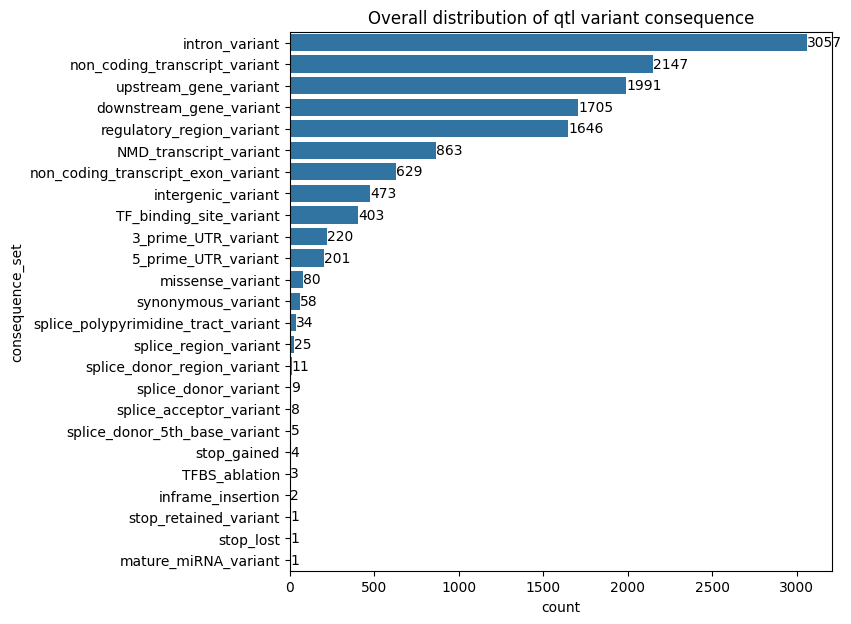

In [9]:
fig, ax = plt.subplots(figsize=(7,7))
ordered_categories = vep_df.explode('consequence_set')['consequence_set'].value_counts().index
y = sns.countplot(vep_df.explode('consequence_set'), y='consequence_set', ax=ax, order=ordered_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant consequence')
plt.show()

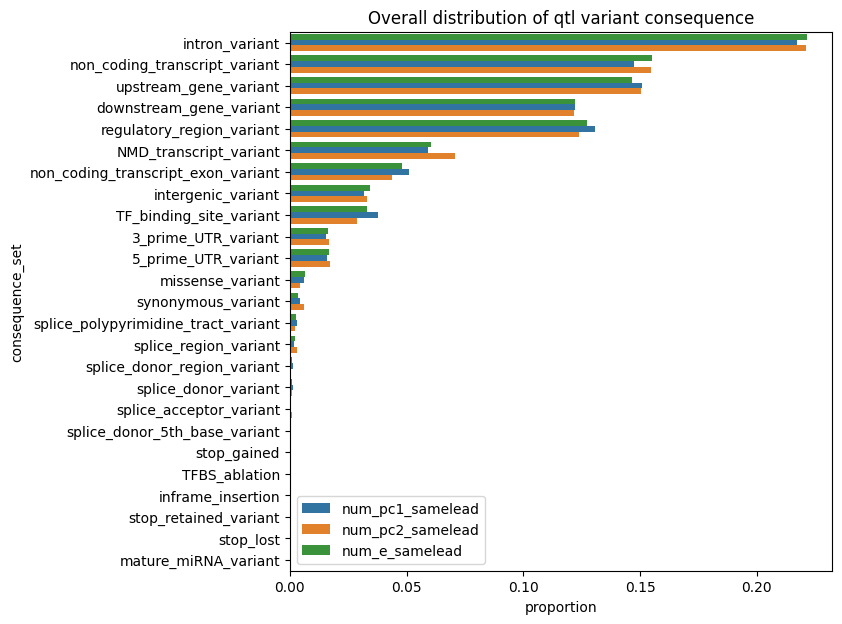

In [10]:
# bar graph with the number of things in each category for pcqtls and eqtls and with each dataset normed individually
fig, ax = plt.subplots(figsize=(7,7))
c_df = vep_df.explode('consequence_set')
datsets = vep_df['orig_cs_dataset'].unique()
for i in range(3):
    if i==0:
        col='num_pc1_samelead'
    if i==1:
        col='num_pc2_samelead'
    if i==2:
        col='num_e_samelead'
    y = sns.countplot(c_df[c_df[col]>0], y='consequence_set', ax=ax, order=ordered_categories, label=col, stat='proportion')
    if i==0:
        for bar in y.patches:
            bar.set_y(bar.get_y() - bar.get_height()/3)
    elif i==1:
        for bar in y.patches:
            bar.set_y(bar.get_y() + 2*bar.get_height()/3)
plt.title('Overall distribution of qtl variant consequence')
for bar in y.patches:
    bar.set_height(bar.get_height()/3)
plt.show()

In [11]:
# error bars on log odds come from error propegation for counts
def calculate_log_odds_error(counts1_positive, counts1_total, counts2_positive, counts2_total):
    counts1_negative = counts1_total-counts1_positive
    counts2_negative = counts2_total-counts2_positive

    # calculate the odds ratio
    or_ratio = (counts1_positive / counts1_negative) / (counts2_positive / counts2_negative)

    # calculate the standard error
    SE_log_OR = np.sqrt(1/counts1_positive - 1/counts1_negative + 1/counts2_positive - 1/counts2_negative)
    lower_bound, upper_bound = np.exp(np.log(or_ratio) - 1.96*SE_log_OR), np.exp(np.log(or_ratio) + 1.96*SE_log_OR)

    return np.log2(or_ratio), np.log2(lower_bound), np.log2(upper_bound)


def get_or_counts(vep_df):
    return vep_df.explode('consequence_set').value_counts('consequence_set')

def get_odds_df(counts1, name1, counts2, name2):
    or_df = pd.DataFrame({name1: counts1, name2: counts2})

    # add the odds ratios and 95% cis
    for idx in or_df.index:
        or_ratio, lower_bound, upper_bound = calculate_log_odds_error(or_df.loc[idx][name1], or_df[name1].sum(), or_df.loc[idx][name2], or_df[name2].sum())
        or_df.loc[idx, 'or_ratio'] = or_ratio
        or_df.loc[idx, 'lower_bound'] = lower_bound
        or_df.loc[idx, 'upper_bound'] = upper_bound

    or_df['upper_err_abs'] = or_df['upper_bound'] - or_df['or_ratio']
    or_df['lower_err_abs'] = or_df['or_ratio'] - or_df['lower_bound']
    return or_df.loc[ordered_categories[ordered_categories.isin(or_df.index)]].reset_index()

def plot_log_odds(or_df, title):
    fig, ax = plt.subplots(figsize=(7,7))
    # reset index to get consequence_set as a column

    ax.errorbar(y=or_df['consequence_set'], x=or_df['or_ratio'], xerr=np.clip(or_df[['lower_err_abs', 'upper_err_abs']].values.transpose(), -3, 3), fmt="o")

    ax.invert_yaxis()
    plt.axvline(0, color='k')
    plt.text(.1, len(or_df)-.2, f'-> {or_df.columns[1]}')
    plt.text(-.1, len(or_df)-.2, f'{or_df.columns[2]} <-', horizontalalignment='right')
    plt.title(title)
    plt.show()

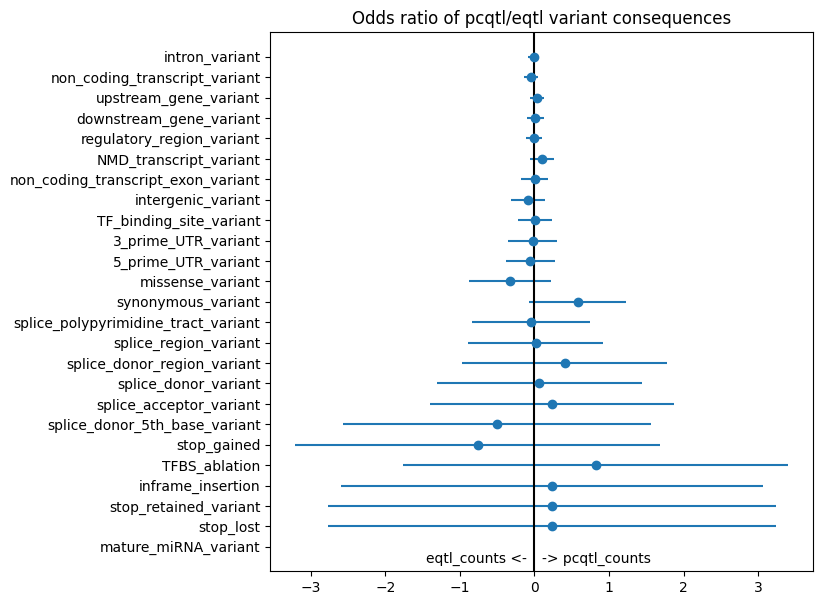

In [16]:
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']>0)])
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts')

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant consequences')

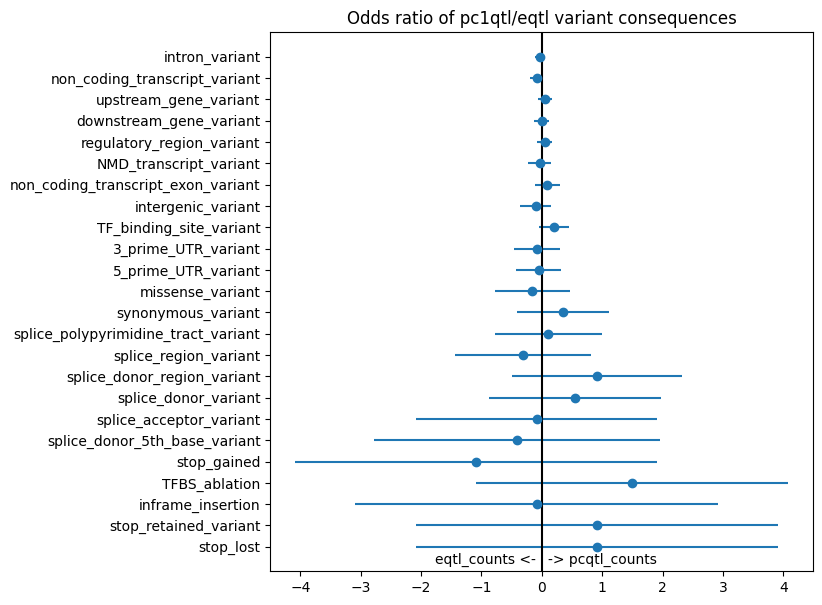

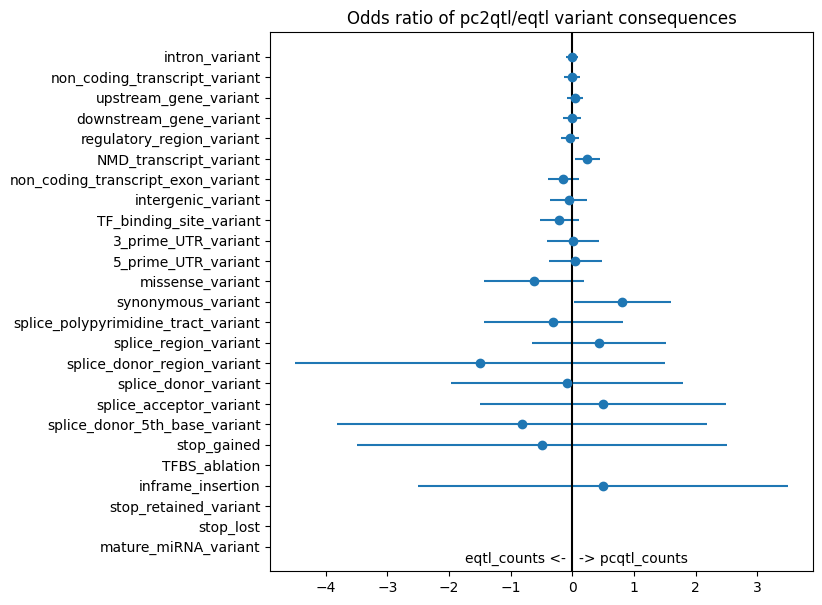

In [18]:
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc1_samelead']>0)])
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts')

# plot
plot_log_odds(or_df, 'Odds ratio of pc1qtl/eqtl variant consequences')

# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc2_samelead']>0)])
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts')

# plot
plot_log_odds(or_df, 'Odds ratio of pc2qtl/eqtl variant consequences')

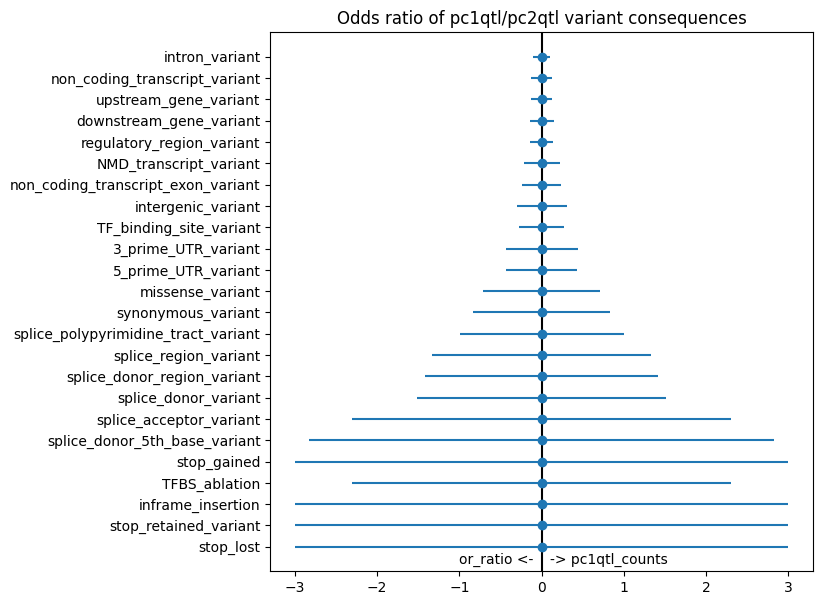

In [19]:
# get counts for all pc1qtl  vs pc2qtl
pc1qtl_counts = get_or_counts(vep_df[(vep_df['num_pc1_samelead']>0)])
pc2qtl_counts = get_or_counts(vep_df[(vep_df['num_pc2_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pc1qtl_counts, 'pc1qtl_counts', pc1qtl_counts, 'pc1qtl_counts')

# plot
plot_log_odds(or_df, 'Odds ratio of pc1qtl/pc2qtl variant consequences')

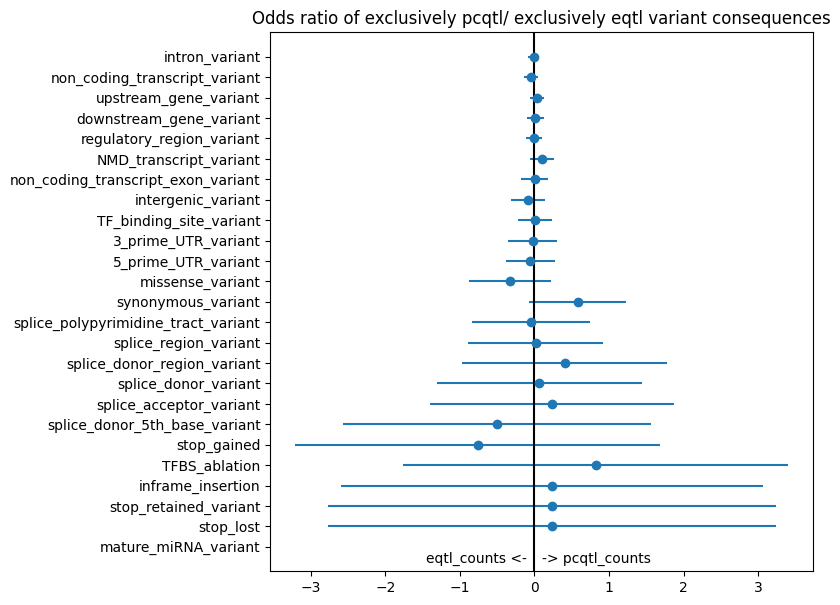

In [20]:
# get counts for all pcqtl that weren't eqtls vs all eqtls that weren't pcqtls


pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']>0) | (vep_df['num_e_samelead']==0)])
eqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']==0) | (vep_df['num_e_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts')

# plot
plot_log_odds(or_df, 'Odds ratio of exclusively pcqtl/ exclusively eqtl variant consequences')

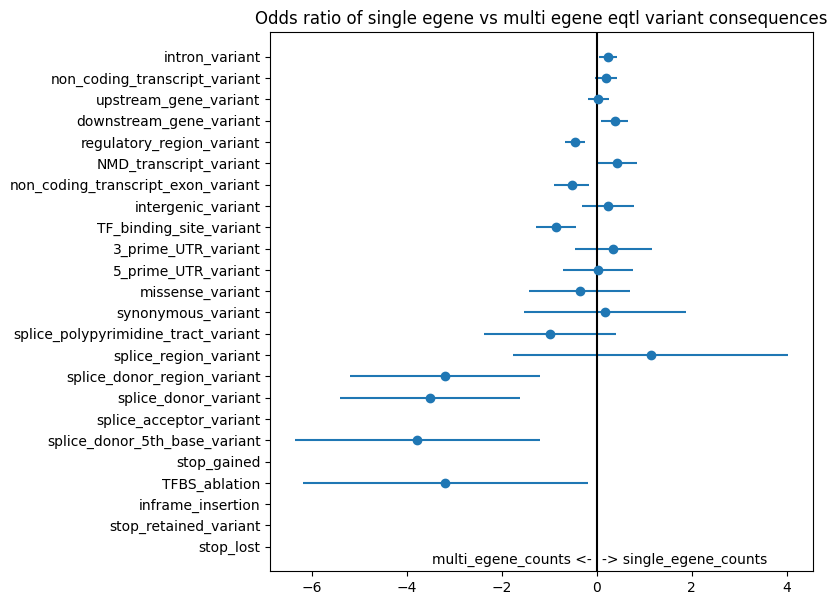

In [21]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 


single_egene_counts = get_or_counts(vep_df[vep_df['num_e_samelead']==1])
multi_egene_counts = get_or_counts(vep_df[vep_df['num_e_samelead']>1])

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts')

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant consequences')

### better control group
have a set of eqtls from all genes on chr22 as a control

In [25]:
control_susie = pd.read_csv(f'{prefix}/output/chr22_eqtl/{tissue_ids[idx]}/{tissue_ids[idx]}.v8.chr22_genes.susie.txt', sep='\t', index_col=0)
control_susie

,phenotype_id,variant_id,pip,af,cs_id
0,ENSG00000206195.10,chr22_15916769_G_A_b38,0.243155,0.244306,1
1,ENSG00000206195.10,chr22_15916941_A_G_b38,0.353783,0.223602,1
2,ENSG00000206195.10,chr22_15917318_G_A_b38,0.353783,0.223602,1
3,ENSG00000232775.6,chr22_15915090_CA_C_b38,0.095092,0.219462,1
4,ENSG00000232775.6,chr22_15916941_A_G_b38,0.443093,0.223602,1
...,...,...,...,...,...
5332,ENSG00000079974.17,chr22_50790482_G_A_b38,0.199461,0.273292,2
5333,ENSG00000079974.17,chr22_50791276_G_GC_b38,0.060012,0.278468,2
5334,ENSG00000079974.17,chr22_50791289_A_T_b38,0.076378,0.277433,2
5335,ENSG00000079974.17,chr22_50794153_T_C_b38,0.085898,0.272257,2


In [27]:
control_susie['cs_full_id'] = control_susie['phenotype_id'].astype(str) + '_e_cs' + control_susie['cs_id'].astype(str) 

def get_lead_var(susie_df):
    return susie_df.loc[susie_df.groupby('cs_full_id')['pip'].idxmax(),['cs_full_id','variant_id']].set_index('cs_full_id')


control_cs_df = pd.DataFrame(pd.Series(control_susie.groupby(['cs_full_id'])['variant_id'].apply(list), name='variant_list'))
control_cs_df['lead_variant_id'] = get_lead_var(control_susie)
control_cs_df


,variant_list,lead_variant_id
cs_full_id,,
ENSG00000015475.18_e_cs1,"[chr22_17643254_T_C_b38, chr22_17648460_C_T_b3...",chr22_17733496_G_C_b38
ENSG00000025708.13_e_cs1,[chr22_50532618_T_C_b38],chr22_50532618_T_C_b38
ENSG00000069998.12_e_cs1,[chr22_17168078_T_C_b38],chr22_17168078_T_C_b38
ENSG00000069998.12_e_cs2,"[chr22_17134961_G_A_b38, chr22_17135261_G_A_b3...",chr22_17135355_A_G_b38
ENSG00000070371.15_e_cs1,"[chr22_19182668_C_T_b38, chr22_19239244_T_C_b3...",chr22_19292035_C_T_b38
...,...,...
ENSG00000283633.1_e_cs1,"[chr22_16601823_C_T_b38, chr22_16607971_G_C_b38]",chr22_16601823_C_T_b38
ENSG00000283633.1_e_cs2,"[chr22_16597059_G_A_b38, chr22_16602700_C_G_b3...",chr22_16602700_C_G_b38
ENSG00000284070.1_e_cs1,"[chr22_24263662_ACCGG_A_b38, chr22_24282513_A_...",chr22_24263662_ACCGG_A_b38
